In [1216]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import os
import warnings
warnings.filterwarnings('ignore')

import 특이점장전ver4
import imp
imp.reload(특이점장전ver4)
from 특이점장전ver4 import Singularity

소형주 : [log(시가총액(단위:십억))]^(-1)
외국인 순매수 강도 : (직전 한 달간 외국인 순매수대금/시가총액) × 100    (단위:%)

시가총액은 단위가 억원으로 나오고 순매수는 단위가 백만원으로 나옴

In [1182]:
### 코스피 200 종목의 종목 코드
def get_filenames_in_folder(folder_path):
    return os.listdir(folder_path)

folder_path = "./KOSPI200_종목코드"
file_list = get_filenames_in_folder(folder_path)

In [1183]:
file_list2 = []
for i in range(len(file_list)):
    file_list2.append(file_list[i].replace('.xlsx',''))

In [1184]:
data10 = pd.read_csv('./datasets/Featur.csv')
data10['종목코드'] = data10['종목코드'].astype(str).apply(lambda x: x.zfill(6))
data10.drop('Unnamed: 0.1', axis=1, inplace=True)
data10.set_index(data10.columns[0], inplace=True)
data10 = data10.replace(0, np.nan)
data10.index = pd.to_datetime(data10.index, format='%Y-%m-%d')
data10.index = pd.to_datetime(data10.index.date)

In [1185]:
date = datetime.strptime('2007-01-01', '%Y-%m-%d') 
date_list2 = []
for i in range(197):
    date_list2.append(date)
    date = date+relativedelta(months=1)

date5 = datetime.strptime('2007-03-01', '%Y-%m-%d') 
date_list5 = []
for i in range(64):
    date_list5.append(date5)
    date5 = date5+relativedelta(months=3)

In [1186]:
sl = Singularity(file_list, date_list5)

In [1187]:
dfdf = []
for k, file_1 in enumerate(file_list):
    code1 = pd.read_excel(f'./추가피처데이터/시가총액/{file_1}')  
    code1.set_index(code1.columns[0], inplace=True)
    code1.columns = code1.iloc[3,:].values
    code1 = code1.iloc[4:,:]

    # code1.iloc[:,2]
    code1.index = pd.to_datetime(code1.index, format='%Y.%m.%d')
    code1.index = pd.to_datetime(code1.index.date)
    code1.sort_index(ascending=True, inplace=True)
    temp1 = code1.iloc[:,6]

    # date = datetime.strptime('2007-01-01', '%Y-%m-%d') 
    # date_list2 = []
    # for i in range(197):
    #     date_list2.append(date)
    #     date = date+relativedelta(months=1)

    value_list = []
    for i in range(len(date_list2)):
        temp_date = date_list2[i]
        tt = temp1[(temp1.index.month == temp_date.month)& (temp1.index.year == temp_date.year)]

        tt_nan_num = tt.isna().sum()
        tt = tt.fillna(0)

        tt_avg = tt.values.sum()/(len(tt) - tt_nan_num)    #-temp_nan_num
        value_list.append(tt_avg)

    code2 = pd.read_excel(f'./추가피처데이터/투자자별매매동향(수급)/{file_1}')    # 375500 000810
    code2.set_index(code2.columns[0], inplace=True)
    code2.columns = code2.iloc[3,:].values
    code2 = code2.iloc[4:,:]

    code2.index = pd.to_datetime(code2.index, format='%Y.%m.%d')
    code2.index = pd.to_datetime(code2.index.date)
    code2.sort_index(ascending=True, inplace=True)

    temp2 = code2.iloc[:,2]


    value_list2 = []
    for i in range(len(date_list2)):
        temp_date2 = date_list2[i]
        tt2 = temp2[(temp2.index.month == temp_date2.month)& (temp2.index.year == temp_date2.year)]

        tt2_nan_num = tt2.isna().sum()
        tt2 = tt2.fillna(0)

        tt2_avg = tt2.values.sum()/(len(tt2) - tt2_nan_num)    #-temp_nan_num
        value_list2.append(tt2_avg)



    df = pd.DataFrame({
            '시가총액' : value_list,
            '투자자 매매동향' : value_list2
        }, index=date_list2)  # 시계열 데이터를 인덱스로 설정

    df['소형주'] = 1 / np.log(df['시가총액']*10)
    df['외국인 순매수 강도'] = (df['투자자 매매동향']/(df['시가총액']*100)) * 100

    # date5 = datetime.strptime('2007-03-01', '%Y-%m-%d') 
    # date_list5 = []
    # for i in range(64):
    #     date_list5.append(date5)
    #     date5 = date5+relativedelta(months=3)

    val1 = []
    val2 = []
    for i in range(len(date_list5)):
        tem1 = df[((df.index.month == date_list5[i].month)|(df.index.month == date_list5[i].month-1)|(df.index.month == date_list5[i].month-2)) & (df.index.year == date_list5[i].year)]

        temp_val1 = tem1['소형주'].mean()
        temp_val2 = tem1['외국인 순매수 강도'].mean()

        val1.append(temp_val1)
        val2.append(temp_val2)

    df2 = pd.DataFrame({
            '소형주' : val1,
            '외국인 순매수 강도' : val2
        }, index=date_list5)  # 시계열 데이터를 인덱스로 설정
    # df2['종목코드'] = .replace('.xlsx','')

    dfdf.append(df2)
    print(f'{k}번째 읽어옴')

0번째 읽어옴
1번째 읽어옴
2번째 읽어옴
3번째 읽어옴
4번째 읽어옴
5번째 읽어옴
6번째 읽어옴
7번째 읽어옴
8번째 읽어옴
9번째 읽어옴
10번째 읽어옴
11번째 읽어옴
12번째 읽어옴
13번째 읽어옴
14번째 읽어옴
15번째 읽어옴
16번째 읽어옴
17번째 읽어옴
18번째 읽어옴
19번째 읽어옴
20번째 읽어옴
21번째 읽어옴
22번째 읽어옴
23번째 읽어옴
24번째 읽어옴
25번째 읽어옴
26번째 읽어옴
27번째 읽어옴
28번째 읽어옴
29번째 읽어옴
30번째 읽어옴
31번째 읽어옴
32번째 읽어옴
33번째 읽어옴
34번째 읽어옴
35번째 읽어옴
36번째 읽어옴
37번째 읽어옴
38번째 읽어옴
39번째 읽어옴
40번째 읽어옴
41번째 읽어옴
42번째 읽어옴
43번째 읽어옴
44번째 읽어옴
45번째 읽어옴
46번째 읽어옴
47번째 읽어옴
48번째 읽어옴
49번째 읽어옴
50번째 읽어옴
51번째 읽어옴
52번째 읽어옴
53번째 읽어옴
54번째 읽어옴
55번째 읽어옴
56번째 읽어옴
57번째 읽어옴
58번째 읽어옴
59번째 읽어옴
60번째 읽어옴
61번째 읽어옴
62번째 읽어옴
63번째 읽어옴
64번째 읽어옴
65번째 읽어옴
66번째 읽어옴
67번째 읽어옴
68번째 읽어옴
69번째 읽어옴
70번째 읽어옴
71번째 읽어옴
72번째 읽어옴
73번째 읽어옴
74번째 읽어옴
75번째 읽어옴
76번째 읽어옴
77번째 읽어옴
78번째 읽어옴
79번째 읽어옴
80번째 읽어옴
81번째 읽어옴
82번째 읽어옴
83번째 읽어옴
84번째 읽어옴
85번째 읽어옴
86번째 읽어옴
87번째 읽어옴
88번째 읽어옴
89번째 읽어옴
90번째 읽어옴
91번째 읽어옴
92번째 읽어옴
93번째 읽어옴
94번째 읽어옴
95번째 읽어옴
96번째 읽어옴
97번째 읽어옴
98번째 읽어옴
99번째 읽어옴
100번째 읽어옴
101번째 읽어옴
102번째 읽어옴
103번째 읽어옴
104번째 읽어옴
105번째 읽어옴
106번째 읽어옴
107번째 읽어옴
108번째 읽어옴
109번째 읽어옴
110번째 읽어옴


In [1188]:
dataframes2 = []
for k, file in enumerate(file_list):
    td = data10.loc[data10['종목코드'] == file.replace('.xlsx','')]
    tdtd = pd.concat([td,dfdf[k]], axis=1)
    tdtd.drop('종목코드', axis=1, inplace=True)

    dataframes2.append(tdtd)

In [1189]:
long_list, short_list = sl.long_short(dataframes2)

In [1190]:
col_list = dataframes2[0].columns
# long_list1 ~ long_list11, short_list1 ~ short_list11 한 번에 변수 할당. 1~11 순서는 col_list참조.
# 예를들어 long_list1에는 '정상영업이익증가율'을 기준으로 반기별로 어느 종목에 long 포지션을 취하는지에 대한 정보가 있다.
for k in range(len(col_list)):
    globals()[f"long_list{k+1}"] = []

for k in range(len(col_list)):
    for i in range(int(len(long_list)/len(col_list))):
        globals()[f"long_list{k+1}"].append(long_list[k+len(col_list)*i])

for k in range(len(col_list)):
    globals()[f"short_list{k+1}"] = []

for k in range(len(col_list)):
    for i in range(int(len(short_list)/len(col_list))):
        globals()[f"short_list{k+1}"].append(short_list[k+len(col_list)*i])

In [1191]:
dfs = []
for k, flie in enumerate(file_list):

    temp_df = pd.read_excel(f'./KOSPI200_종목코드/{flie}')   # 375500 000810
    temp_df.columns = temp_df.iloc[2,:].values
    temp_df = temp_df.iloc[3:,:]
    # data6['시점'] = data6['시점'].astype(str)
    temp_df.set_index(temp_df.columns[0], inplace=True)

    temp_df.index = pd.to_datetime(temp_df.index, format='%Y.%m.%d')
    temp_df.index = pd.to_datetime(temp_df.index.date)
    temp_df.sort_index(ascending=True, inplace=True)

    globals()[f"temp{k+1}"] = temp_df

    dfs.append(globals()[f"temp{k+1}"])
    print(f'{k}번째 읽어옴')

0번째 읽어옴
1번째 읽어옴
2번째 읽어옴
3번째 읽어옴
4번째 읽어옴
5번째 읽어옴
6번째 읽어옴
7번째 읽어옴
8번째 읽어옴
9번째 읽어옴
10번째 읽어옴
11번째 읽어옴
12번째 읽어옴
13번째 읽어옴
14번째 읽어옴
15번째 읽어옴
16번째 읽어옴
17번째 읽어옴
18번째 읽어옴
19번째 읽어옴
20번째 읽어옴
21번째 읽어옴
22번째 읽어옴
23번째 읽어옴
24번째 읽어옴
25번째 읽어옴
26번째 읽어옴
27번째 읽어옴
28번째 읽어옴
29번째 읽어옴
30번째 읽어옴
31번째 읽어옴
32번째 읽어옴
33번째 읽어옴
34번째 읽어옴
35번째 읽어옴
36번째 읽어옴
37번째 읽어옴
38번째 읽어옴
39번째 읽어옴
40번째 읽어옴
41번째 읽어옴
42번째 읽어옴
43번째 읽어옴
44번째 읽어옴
45번째 읽어옴
46번째 읽어옴
47번째 읽어옴
48번째 읽어옴
49번째 읽어옴
50번째 읽어옴
51번째 읽어옴
52번째 읽어옴
53번째 읽어옴
54번째 읽어옴
55번째 읽어옴
56번째 읽어옴
57번째 읽어옴
58번째 읽어옴
59번째 읽어옴
60번째 읽어옴
61번째 읽어옴
62번째 읽어옴
63번째 읽어옴
64번째 읽어옴
65번째 읽어옴
66번째 읽어옴
67번째 읽어옴
68번째 읽어옴
69번째 읽어옴
70번째 읽어옴
71번째 읽어옴
72번째 읽어옴
73번째 읽어옴
74번째 읽어옴
75번째 읽어옴
76번째 읽어옴
77번째 읽어옴
78번째 읽어옴
79번째 읽어옴
80번째 읽어옴
81번째 읽어옴
82번째 읽어옴
83번째 읽어옴
84번째 읽어옴
85번째 읽어옴
86번째 읽어옴
87번째 읽어옴
88번째 읽어옴
89번째 읽어옴
90번째 읽어옴
91번째 읽어옴
92번째 읽어옴
93번째 읽어옴
94번째 읽어옴
95번째 읽어옴
96번째 읽어옴
97번째 읽어옴
98번째 읽어옴
99번째 읽어옴
100번째 읽어옴
101번째 읽어옴
102번째 읽어옴
103번째 읽어옴
104번째 읽어옴
105번째 읽어옴
106번째 읽어옴
107번째 읽어옴
108번째 읽어옴
109번째 읽어옴
110번째 읽어옴


In [1214]:
long_rate_sum = []
for i in range(len(short_list1)):
    print(f'{i}번째 기간 읽어오기 완료')  
    date = date_list5[i]
    # 특정 기간에서 특정 팩터 기준으로 long칠 종목들
    long_tem = short_list1[i]

    len_code = len(long_tem)
    len_code2 = len(long_tem)
    len_code3 = len(long_tem)

    # long_temp = []  ##
    # 상위 20% 데이터 롱치자
    long_temp_rate = 0
    long_temp_rate2 = 0
    long_temp_rate3 = 0
    for code_tem in long_tem:

        ind = file_list.index(code_tem+'.xlsx')
        temp = dfs[ind][((dfs[ind].index.month == date.month))& (dfs[ind].index.year == date.year)]['종가(원)']
        temp2 = dfs[ind][((dfs[ind].index.month == date.month-1))& (dfs[ind].index.year == date.year)]['종가(원)']
        temp3 = dfs[ind][((dfs[ind].index.month == date.month-2))& (dfs[ind].index.year == date.year)]['종가(원)']
        # |(dfs[ind].index.month == date.month-1)|(dfs[ind].index.month == date.month-2)

        if temp.empty != True:
            long_temp_rate = long_temp_rate + (temp[-1] - temp[0])/temp[0]
            # long_temp.append(long_temp_rate)    ##
        else:
            len_code = len_code -1 

        if temp2.empty != True:
            long_temp_rate2 = long_temp_rate2 + (temp2[-1] - temp2[0])/temp2[0]
            # long_temp.append(long_temp_rate)    ##
        else:
            len_code2 = len_code2 -1 

        if temp3.empty != True:
            long_temp_rate3 = long_temp_rate3 + (temp3[-1] - temp3[0])/temp3[0]
            # long_temp.append(long_temp_rate)    ##
        else:
            len_code3 = len_code3 -1 
    
    if len_code == 0:
        long_temp_rate = 0
    else:
        long_temp_rate = long_temp_rate/len_code
    
    if len_code2 == 0:
        long_temp_rate2 = 0
    else:
        long_temp_rate2 = long_temp_rate2/len_code2
    
    if len_code3 == 0:
        long_temp_rate3 = 0
    else:
        long_temp_rate3 = long_temp_rate3/len_code3

    long_rate_sum.append(long_temp_rate3)
    print(f'{i}번째 기간 읽어오기 완료')      
    long_rate_sum.append(long_temp_rate2)
    print(f'{i}번째 기간 읽어오기 완료')      
    long_rate_sum.append(long_temp_rate)
    print(f'{i}번째 기간 읽어오기 완료')      
    # print(f'{i}번째 기간 읽어오기 완료')         

0번째 기간 읽어오기 완료
0번째 기간 읽어오기 완료
0번째 기간 읽어오기 완료
0번째 기간 읽어오기 완료
1번째 기간 읽어오기 완료
1번째 기간 읽어오기 완료
1번째 기간 읽어오기 완료
1번째 기간 읽어오기 완료
2번째 기간 읽어오기 완료
2번째 기간 읽어오기 완료
2번째 기간 읽어오기 완료
2번째 기간 읽어오기 완료
3번째 기간 읽어오기 완료
3번째 기간 읽어오기 완료
3번째 기간 읽어오기 완료
3번째 기간 읽어오기 완료
4번째 기간 읽어오기 완료
4번째 기간 읽어오기 완료
4번째 기간 읽어오기 완료
4번째 기간 읽어오기 완료
5번째 기간 읽어오기 완료
5번째 기간 읽어오기 완료
5번째 기간 읽어오기 완료
5번째 기간 읽어오기 완료
6번째 기간 읽어오기 완료
6번째 기간 읽어오기 완료
6번째 기간 읽어오기 완료
6번째 기간 읽어오기 완료
7번째 기간 읽어오기 완료
7번째 기간 읽어오기 완료
7번째 기간 읽어오기 완료
7번째 기간 읽어오기 완료
8번째 기간 읽어오기 완료
8번째 기간 읽어오기 완료
8번째 기간 읽어오기 완료
8번째 기간 읽어오기 완료
9번째 기간 읽어오기 완료
9번째 기간 읽어오기 완료
9번째 기간 읽어오기 완료
9번째 기간 읽어오기 완료
10번째 기간 읽어오기 완료
10번째 기간 읽어오기 완료
10번째 기간 읽어오기 완료
10번째 기간 읽어오기 완료
11번째 기간 읽어오기 완료
11번째 기간 읽어오기 완료
11번째 기간 읽어오기 완료
11번째 기간 읽어오기 완료
12번째 기간 읽어오기 완료
12번째 기간 읽어오기 완료
12번째 기간 읽어오기 완료
12번째 기간 읽어오기 완료
13번째 기간 읽어오기 완료
13번째 기간 읽어오기 완료
13번째 기간 읽어오기 완료
13번째 기간 읽어오기 완료
14번째 기간 읽어오기 완료
14번째 기간 읽어오기 완료
14번째 기간 읽어오기 완료
14번째 기간 읽어오기 완료
15번째 기간 읽어오기 완료
15번째 기간 읽어오기 완료
15번째 기간 읽어오기 완료
15번째 기간 읽어오기 완료
16번째 기간 읽어오기 완료


In [1215]:
len(long_rate_sum)

192

In [1217]:
long_rate1, short_rate1 = sl.get_posterior_rate(short_list1, long_list1, dfs)
long_rate2, short_rate2 = sl.get_posterior_rate(short_list2, long_list2, dfs)
long_rate3, short_rate3 = sl.get_posterior_rate(short_list3, long_list3, dfs)
long_rate4, short_rate4 = sl.get_posterior_rate(short_list4, long_list4, dfs)
long_rate5, short_rate5 = sl.get_posterior_rate(long_list5, short_list5, dfs)
long_rate6, short_rate6 = sl.get_posterior_rate(long_list6, short_list6, dfs)
long_rate7, short_rate7 = sl.get_posterior_rate(long_list7, short_list7, dfs)
long_rate8, short_rate8 = sl.get_posterior_rate(long_list8, short_list8, dfs)
long_rate9, short_rate9 = sl.get_posterior_rate(short_list9, long_list9, dfs)
long_rate10, short_rate10 = sl.get_posterior_rate(long_list10, short_list10, dfs)
long_rate11, short_rate11 = sl.get_posterior_rate(long_list11, short_list11, dfs)
long_rate12, short_rate12 = sl.get_posterior_rate(long_list12, short_list12, dfs)
long_rate13, short_rate13 = sl.get_posterior_rate(long_list13, short_list13, dfs)

In [1202]:
ff = []

ff.append(1)
ff.append(2)
ff.append(13)

In [1203]:
ff

[1, 2, 13]

In [1199]:
len(long_rate1)

64

In [1193]:
rate1 = [a + b for a, b in zip(long_rate1, short_rate1)]
rate2 = [a + b for a, b in zip(long_rate2, short_rate2)]
rate3 = [a + b for a, b in zip(long_rate3, short_rate3)]
rate4 = [a + b for a, b in zip(long_rate4, short_rate4)]
rate5 = [a + b for a, b in zip(long_rate5, short_rate5)]
rate6 = [a + b for a, b in zip(long_rate6, short_rate6)]
rate7 = [a + b for a, b in zip(long_rate7, short_rate7)]
rate8 = [a + b for a, b in zip(long_rate8, short_rate8)]
rate9 = [a + b for a, b in zip(long_rate9, short_rate9)]
rate10 = [a + b for a, b in zip(long_rate10, short_rate10)]
rate11 = [a + b for a, b in zip(long_rate11, short_rate11)]
rate12 = [a + b for a, b in zip(long_rate12, short_rate12)]
rate13 = [a + b for a, b in zip(long_rate13, short_rate13)]

In [1195]:
len(rate13)

64

In [1194]:
date6 = datetime.strptime('2007-01-01', '%Y-%m-%d') 
date_list6 = []
for i in range(192):
    date_list6.append(date6)
    date6 = date6+relativedelta(months=1)

In [1069]:
main_data = pd.DataFrame({
    'PER_사후': rate1,
    'PBR_사후': rate2,
    'PCR_사후': rate3,
    'PSR_사후': rate4,
    '배당수익률_사후': rate5,
    '정상영업이익증가율_사후': rate6,
    '순이익증가율_사후': rate7,
    '1주당순이익_사후': rate8,
    '부채비율_사후': rate9,
    '매출액정상영업이익률_사후': rate10,
    '매출액증가율_사후': rate11,
    '소형주_사후' : rate12,
    '외국인 순매수 강도_사후' : rate13
}, index=date_list5)  # 시계열 데이터를 인덱스로 설정

main_data2 = pd.DataFrame({
    'PER_사후': long_rate1,
    'PBR_사후': long_rate2,
    'PCR_사후': long_rate3,
    'PSR_사후': long_rate4,
    '배당수익률_사후': long_rate5,
    '정상영업이익증가율_사후': long_rate6,
    '순이익증가율_사후': long_rate7,
    '1주당순이익_사후': long_rate8,
    '부채비율_사후': long_rate9,
    '매출액정상영업이익률_사후': long_rate10,
    '매출액증가율_사후': long_rate11,
    '소형주_사후': long_rate12,
    '외국인 순매수 강도_사후': long_rate13
}, index=date_list5)  # 시계열 데이터를 인덱스로 설정

In [1070]:
main_data3 = pd.DataFrame({
    'PER_사후': short_rate1,
    'PBR_사후': short_rate2,
    'PCR_사후': short_rate3,
    'PSR_사후': short_rate4,
    '배당수익률_사후': short_rate5,
    '정상영업이익증가율_사후': short_rate6,
    '순이익증가율_사후': short_rate7,
    '1주당순이익_사후': short_rate8,
    '부채비율_사후': short_rate9,
    '매출액정상영업이익률_사후': short_rate10,
    '매출액증가율_사후': short_rate11,
    '소형주_사후': short_rate12,
    '외국인 순매수 강도_사후': short_rate13
}, index=date_list5)  # 시계열 데이터를 인덱스로 설정

In [1180]:
len(short_rate1)

64

In [1071]:
len(long_list6[16])

25

In [1173]:
data = main_data.iloc[12:,:]

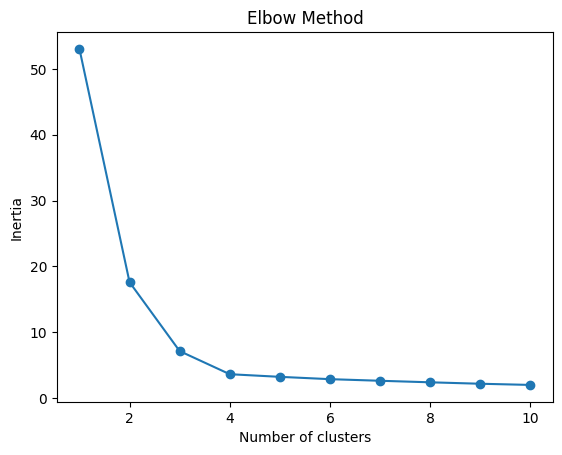

In [1174]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 가정: 'df'는 시계열 데이터가 인덱스이고 다른 여러 컬럼들이 있는 데이터 프레임입니다.

# 데이터를 numpy array로 변환
# scaler = StandardScaler()
# X = scaler.fit_transform(data.values)
X = data.values
# X = data.values

# 클러스터의 개수를 1부터 10까지 변화시키면서 KMeans 클러스터링 수행
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    inertias.append(kmeans.inertia_)

# 클러스터의 개수에 따른 Inertia 값 그래프 그리기
plt.plot(range(1, 11), inertias, 'o-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [1177]:
# 최적의 클러스터 개수 선택 (예: 3)
optimal_k = 4

# 최적의 클러스터 개수로 K-means 클러스터링 수행
kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(X)

# 클러스터링 결과 가져오기
labels = kmeans.labels_

In [1178]:
from collections import Counter

# 레이블 별 개수 확인
label_counts = Counter(labels)

# 레이블 별 개수 출력
for label, count in label_counts.items():
    print(f'Label {label}: {count}개')

Label 0: 25개
Label 2: 16개
Label 1: 7개
Label 3: 4개


In [1179]:
data['lables'] = labels
data.groupby(['lables']).mean()

# main_data['lables'] = labels
# main_data.groupby(['lables']).mean()

,PER_사후,PBR_사후,PCR_사후,PSR_사후,배당수익률_사후,정상영업이익증가율_사후,순이익증가율_사후,1주당순이익_사후,부채비율_사후,매출액정상영업이익률_사후,매출액증가율_사후,소형주_사후,외국인 순매수 강도_사후
lables,,,,,,,,,,,,,
0,0.025737,0.039380,0.026569,0.071993,0.021782,-0.017546,0.003155,0.001973,-0.009368,0.034324,0.008174,0.009680,0.091648
1,-0.201055,-0.217117,-0.234156,-0.218953,-0.136645,0.070847,0.080811,0.060441,-0.008276,-0.058938,0.112715,0.076159,0.055908
2,-0.050056,-0.091949,-0.049350,-0.077375,-0.046630,-0.012840,0.009389,0.028697,-0.094036,-0.050137,0.028643,-0.001682,0.117754
3,-0.112739,-0.161541,-0.136371,0.077968,-0.019905,-0.110659,0.121733,-0.102875,0.214714,-0.098694,-0.074430,0.404662,0.087569


In [1144]:
labels

array([1, 3, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 2, 1, 1, 0, 1, 1, 3, 0,
       1, 0, 3, 0, 2, 0, 3, 2, 0, 0, 1, 3, 1, 1, 1, 1, 2, 2, 1, 0, 1, 1,
       0, 1, 1, 0, 2, 2, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1])

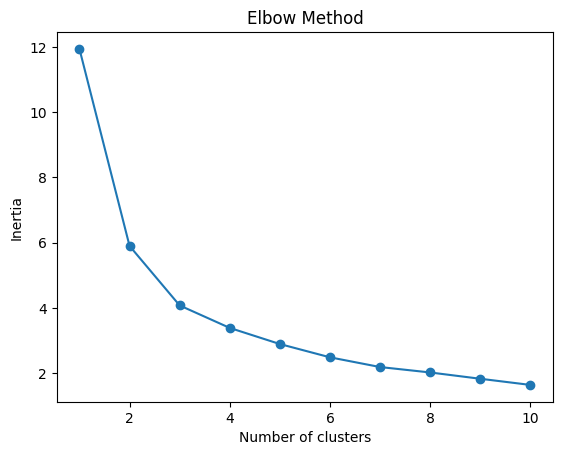

In [1078]:
scaler = StandardScaler()
# X2 = scaler.fit_transform(main_data2.values)
# X2 = scaler.fit_transform(main_data2.values)
X2 = main_data2.values

# 클러스터의 개수를 1부터 10까지 변화시키면서 KMeans 클러스터링 수행
inertias = []
for k in range(1, 11):
    kmeans2 = KMeans(n_clusters=k, random_state=0).fit(X2)
    inertias.append(kmeans2.inertia_)

# 클러스터의 개수에 따른 Inertia 값 그래프 그리기
plt.plot(range(1, 11), inertias, 'o-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [1079]:
# 최적의 클러스터 개수 선택 (예: 3)
optimal_k = 4

# 최적의 클러스터 개수로 K-means 클러스터링 수행
kmeans2 = KMeans(n_clusters=optimal_k, random_state=0).fit(X2)

# 클러스터링 결과 가져오기
labels2 = kmeans2.labels_

In [1080]:
# 레이블 별 개수 확인
label_counts2 = Counter(labels2)

# 레이블 별 개수 출력
for label, count in label_counts2.items():
    print(f'Label {label}: {count}개')

Label 1: 24개
Label 2: 16개
Label 0: 18개
Label 3: 6개


In [1081]:
main_data2['lables'] = labels2
main_data2.groupby(['lables']).mean()

,PER_사후,PBR_사후,PCR_사후,PSR_사후,배당수익률_사후,정상영업이익증가율_사후,순이익증가율_사후,1주당순이익_사후,부채비율_사후,매출액정상영업이익률_사후,매출액증가율_사후,소형주_사후,외국인 순매수 강도_사후
lables,,,,,,,,,,,,,
0,-0.063075,-0.070899,-0.062405,-0.073130,-0.055247,-0.050155,-0.040196,-0.038199,-0.071462,-0.061750,-0.046917,-0.056238,0.006172
1,0.042978,0.028918,0.037767,0.044750,0.033061,0.026920,0.048777,0.032411,0.031574,0.046095,0.058157,0.090123,0.100120
2,0.112439,0.123736,0.130446,0.196180,0.090191,0.178126,0.170998,0.172243,0.151824,0.151149,0.205392,0.240136,0.194745
3,-0.173016,-0.206612,-0.159410,-0.190837,-0.166067,-0.161646,-0.120470,-0.105628,-0.207307,-0.197523,-0.133861,-0.200581,-0.094937


In [1082]:
labels2

array([1, 2, 2, 0, 0, 1, 3, 3, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1, 3,
       2, 1, 1, 0, 2, 0, 2, 0, 1, 0, 2, 2, 0, 0, 1, 2, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 3, 2, 2, 2, 2, 2, 0, 0, 0, 3, 0, 1])

In [1083]:
labels3

array([2, 0, 3, 2, 1, 3, 1, 1, 3, 0, 0, 2, 2, 3, 3, 2, 2, 2, 1, 3, 2, 1,
       3, 2, 3, 1, 3, 2, 3, 2, 3, 1, 0, 3, 1, 2, 2, 3, 2, 1, 3, 3, 2, 3,
       2, 1, 2, 1, 3, 1, 1, 2, 1, 0, 0, 0, 2, 3, 1, 1, 1, 1, 1, 2])

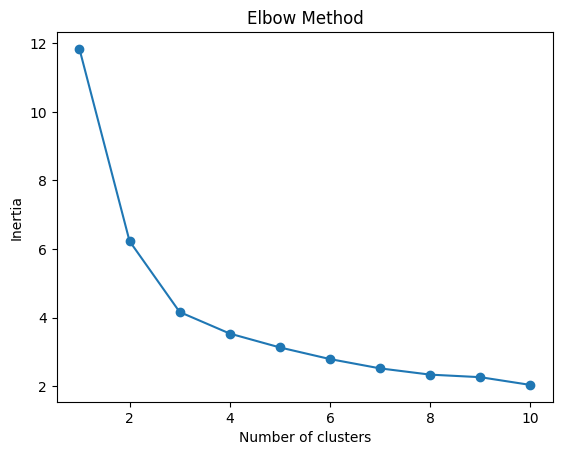

In [1084]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 가정: 'df'는 시계열 데이터가 인덱스이고 다른 여러 컬럼들이 있는 데이터 프레임입니다.

# 데이터를 numpy array로 변환
# scaler = StandardScaler()
# X = scaler.fit_transform(main_data.values)
X3 = main_data3.values
# X = data.values

# 클러스터의 개수를 1부터 10까지 변화시키면서 KMeans 클러스터링 수행
inertias = []
for k in range(1, 11):
    kmeans3 = KMeans(n_clusters=k, random_state=0).fit(X3)
    inertias.append(kmeans3.inertia_)

# 클러스터의 개수에 따른 Inertia 값 그래프 그리기
plt.plot(range(1, 11), inertias, 'o-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [1085]:
# 최적의 클러스터 개수 선택 (예: 3)
optimal_k = 4

# 최적의 클러스터 개수로 K-means 클러스터링 수행
kmeans3 = KMeans(n_clusters=optimal_k, random_state=0).fit(X3)

# 클러스터링 결과 가져오기
labels3 = kmeans3.labels_

In [1086]:
# 레이블 별 개수 확인
label_counts3 = Counter(labels3)

# 레이블 별 개수 출력
for label, count in label_counts3.items():
    print(f'Label {label}: {count}개')

Label 2: 20개
Label 0: 7개
Label 3: 18개
Label 1: 19개


In [1087]:
main_data3['lables'] = labels3
main_data3.groupby(['lables']).mean()

,PER_사후,PBR_사후,PCR_사후,PSR_사후,배당수익률_사후,정상영업이익증가율_사후,순이익증가율_사후,1주당순이익_사후,부채비율_사후,매출액정상영업이익률_사후,매출액증가율_사후,소형주_사후,외국인 순매수 강도_사후
lables,,,,,,,,,,,,,
0,-0.280105,-0.299291,-0.289455,-0.258135,-0.234669,-0.245469,-0.188861,-0.219796,-0.171999,-0.203351,-0.239954,-0.170540,-0.210663
1,0.068738,0.072802,0.071074,0.071791,0.085911,0.114191,0.104865,0.095286,0.071883,0.057075,0.121675,0.087952,0.111706
2,-0.037960,-0.044706,-0.038484,-0.022819,-0.024960,-0.015848,-0.015295,-0.023742,-0.041006,-0.009208,-0.014918,-0.036934,0.021206
3,-0.106131,-0.118643,-0.126383,-0.106205,-0.093841,-0.115759,-0.066863,-0.096500,-0.079847,-0.114773,-0.101981,-0.044394,-0.056997


In [1088]:
labels3

array([2, 0, 3, 2, 1, 3, 1, 1, 3, 0, 0, 2, 2, 3, 3, 2, 2, 2, 1, 3, 2, 1,
       3, 2, 3, 1, 3, 2, 3, 2, 3, 1, 0, 3, 1, 2, 2, 3, 2, 1, 3, 3, 2, 3,
       2, 1, 2, 1, 3, 1, 1, 2, 1, 0, 0, 0, 2, 3, 1, 1, 1, 1, 1, 2])